## Forecast vehicular traffic trend using Seasonal ARIMA

### Our data contains hourly data with multiple seasonalities - daily as well as weekly

In [4]:
# Import modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')

In [5]:
#load the data
data = pd.read_csv('D:\\Study\\DataScience\\Data\\MachineLearningData\\TrafficData\\hourlydata.csv')

In [6]:
# Convert the Index to DatetimeIndex
data = data.set_index('time')
data.index = pd.to_datetime(data.index)

In [12]:
# Resample the hourly data into daily data
data = data.resample('H').sum()
data = data.iloc[:-140,:]

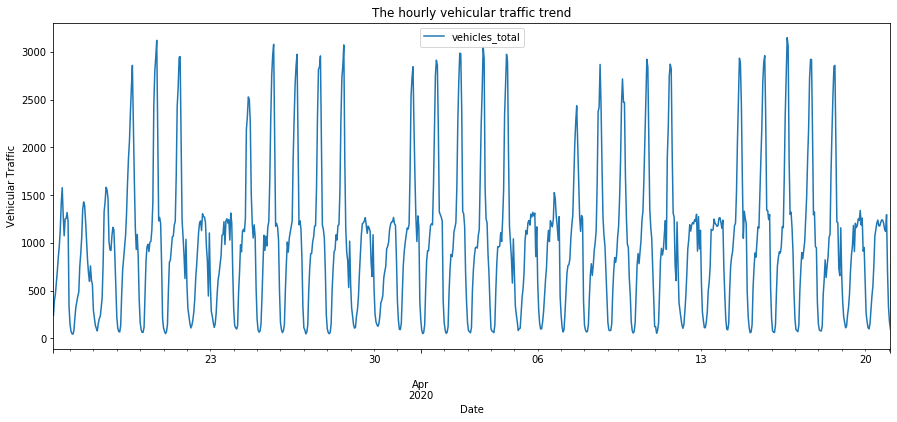

In [13]:
# Plot the dataframe to visualize time series data
data.plot(figsize=(15, 6))
plt.xlabel('Date')
plt.ylabel('Vehicular Traffic')
plt.title('The hourly vehicular traffic trend')
plt.show()

## SARIMAX model to analyze multiple seasonalities - Hourly and Weekly

In [14]:
# Import statmdoels for timeseries
import statsmodels.api as sm

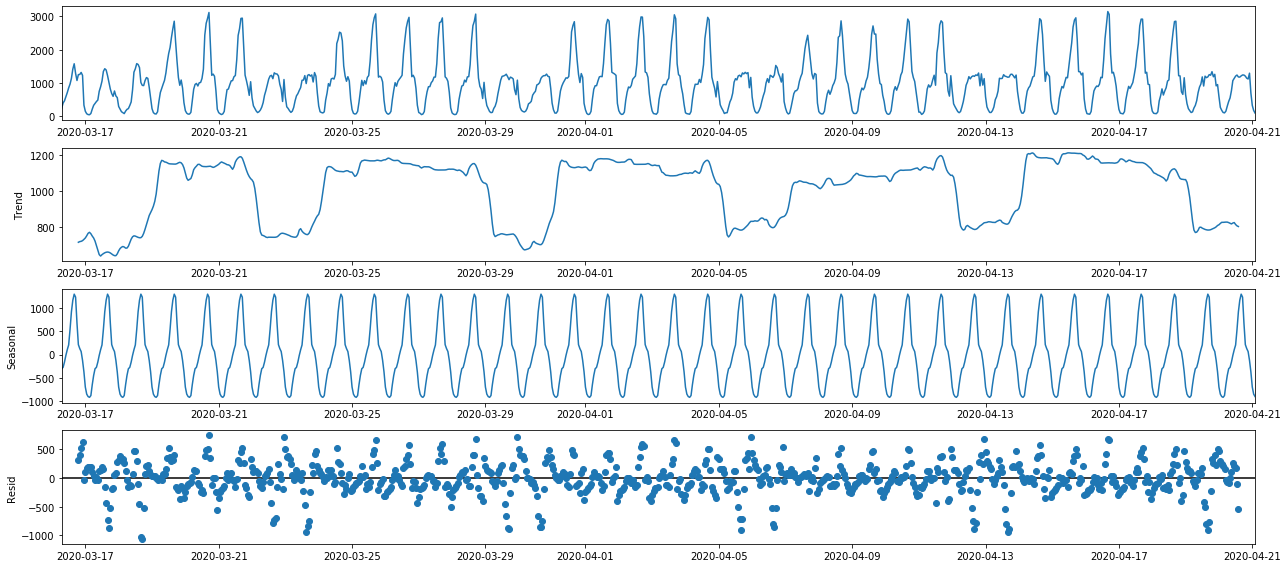

In [15]:
# Use decomposition method to visualize the various components of time series data
from pylab import rcParams

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(data, model='additive', freq = 24)
fig = decomposition.plot()
plt.show()

### Augmented Dickey Fuller test (ADF Test) is a common statistical test used to test whether a given Time series is stationary or not. 

In [16]:
# Perform ADF test to check the stationarity of the Time Series data

# Define function for ADF test
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
adf_test(data['vehicles_total'])

Results of Dickey-Fuller Test:
Test Statistic                  -3.305548
p-value                          0.014632
#Lags Used                      21.000000
Number of Observations Used    838.000000
Critical Value (1%)             -3.438177
Critical Value (5%)             -2.864995
Critical Value (10%)            -2.568610
dtype: float64


Test for stationarity: If the test statistic is less than the critical value, we can reject the null hypothesis (aka the series is stationary). When the test statistic is greater than the critical value, we fail to reject the null hypothesis (which means the series is not stationary).

In our above example, the **test statistic > critical value**, which implies that the series is **not stationary**. This confirms our original observation which we initially saw in the visual test.

In [17]:
# Split the time series data into training and test data
y = data['vehicles_total']
y_to_train = y.iloc[:(len(y)-355)]
y_to_test = y.iloc[(len(y)-355):]

## Visualize training and testing datasets

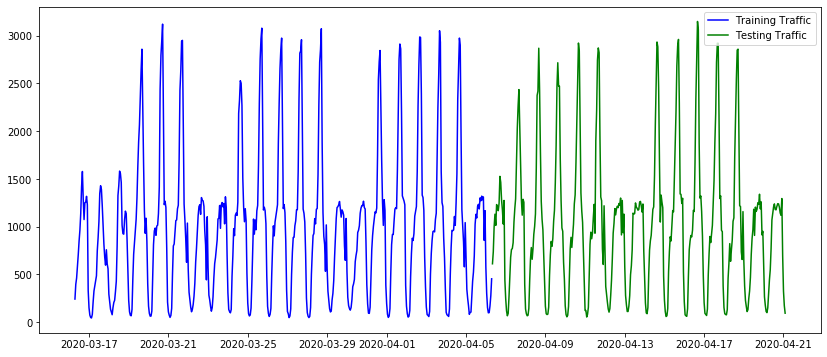

In [18]:
plt.figure(figsize=(14,6))
plt.plot(y_to_train, 'b-', label='Training Traffic')
plt.plot(y_to_test, 'g', label='Testing Traffic')
plt.legend(loc='upper right', frameon=True)
plt.show()

In [19]:
import itertools

p = d = q = range(0, 2)
#p = d = q = (0, 1, 2, 3)
pdq = list(itertools.product(p, d, q))
#seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
# Our frequency is weekly so with data resampled as daily the value of m would be 7 
seasonal_pdq = [(x[0], x[1], x[2], 168) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...\n')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...

SARIMAX: (0, 0, 1) x (0, 0, 1, 168)
SARIMAX: (0, 0, 1) x (0, 1, 0, 168)
SARIMAX: (0, 1, 0) x (0, 1, 1, 168)
SARIMAX: (0, 1, 0) x (1, 0, 0, 168)


## Fit SARIMAX model

In [20]:
#From the param_dict **ARIMA (5, 1, 0) x (0, 1, 0, 24*7) -  gives the minimum AIC value

model = sm.tsa.statespace.SARIMAX(data, order=(5, 1, 0), seasonal_order=(0, 1, 0, 24*7),
                                            enforce_stationarity=False, enforce_invertibility=False)

results = model.fit()

In [ ]:
# Save the model with order=(5, 1, 0), seasonal_order=(0, 0, 0, 24*7)

results.save('D:\\Study\\DataScience\\Data\\MachineLearningData\\TrafficData\\model_sarimax.pkl')

In [22]:
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2238      0.024     -9.264      0.000      -0.271      -0.176
ar.L2         -0.0859      0.026     -3.303      0.001      -0.137      -0.035
ar.L3         -0.1818      0.027     -6.823      0.000      -0.234      -0.130
ar.L4         -0.1627      0.027     -5.985      0.000      -0.216      -0.109
ar.L5         -0.1641      0.029     -5.635      0.000      -0.221      -0.107
sigma2      3.016e+04    996.446     30.264      0.000    2.82e+04    3.21e+04


## View model diagonastics

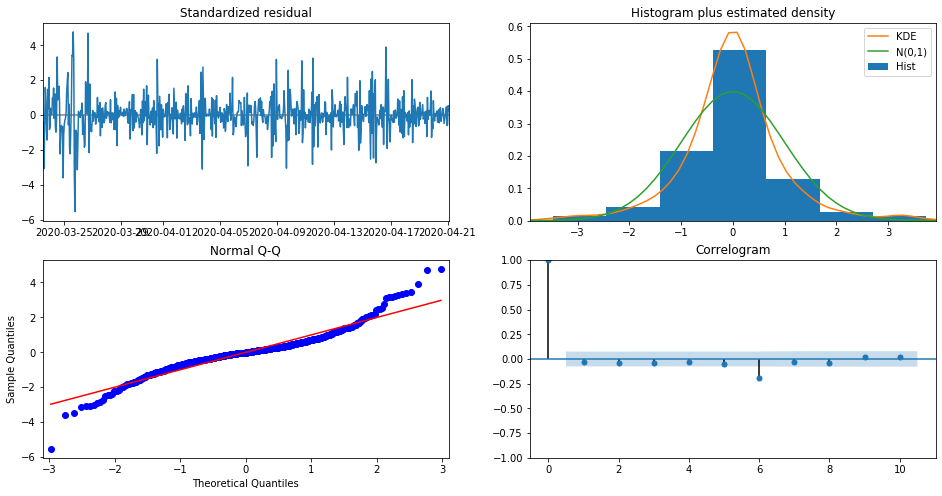

In [23]:
# Run model diagonstics
results.plot_diagnostics(figsize=(16, 8))
plt.show()

## Evaluate the SARIMAX model

In [47]:
y_predict = results.predict(start= '2020-04-06 08:00:00', end= '2020-04-21 02:00:00')

In [49]:
# Create a similar date range equal to future periods.
dt_forecast = pd.date_range(start='2020-04-06 08:00:00', end= '2020-04-21 02:00:00', freq='H')

In [50]:
# Create a dataframe to index as dt_forecast and data as y_predict
df_y_predict = pd.DataFrame(index=dt_forecast, data=y_predict)
df_y_predict.columns = ['vehicular_total']

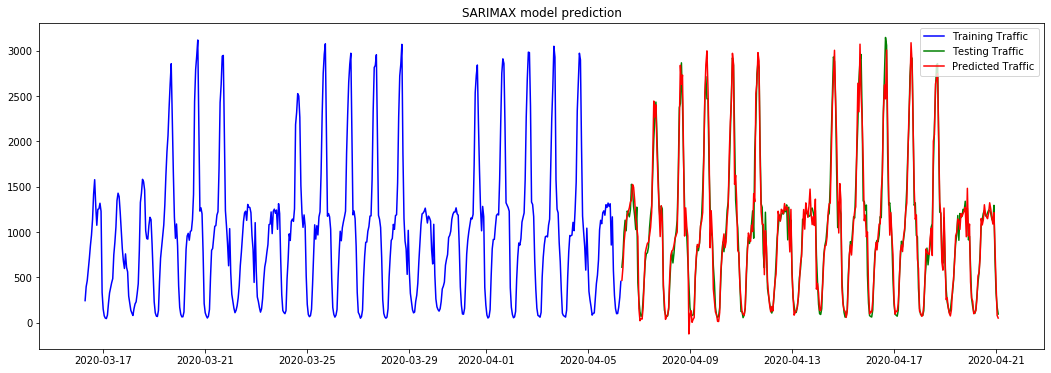

In [53]:
# Plot the results
plt.figure(figsize=(18,6))
plt.plot(y_to_train, 'b-', label='Training Traffic')
plt.plot(y_to_test, 'g', label='Testing Traffic')
plt.plot(df_y_predict.index, df_y_predict.vehicular_total, 'r', label='Predicted Traffic')
plt.legend(loc='upper right', frameon=True)
plt.title('SARIMAX model prediction')
plt.show()

In [62]:
# Calculate RMSE and MAPE of the model

from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_absolute_error(y_to_test, y_predict)

mae = mean_absolute_error(y_to_test, y_predict)

rmse = np.sqrt(mse)

print('Root Mean Squared Error: {}'.format(np.round(rmse, 4)))
print('Mean Absolute Error: {}'.format(np.round(mae, 4)))

Root Mean Squared Error: 10.4842
Mean Absolute Error: 109.9191


## Compare forecast for next 400 hours

In [37]:
# Create a similar date range equal to future periods.
dt1 = pd.date_range(start='2020-04-21 03:00:00', periods=400, freq='H')

In [38]:
# Create a dataframe to index as y_test and data as exog_forecast
forecast = pd.DataFrame(index=dt1, data=pred_uc.predicted_mean)
forecast.columns = ['vehicular_total']

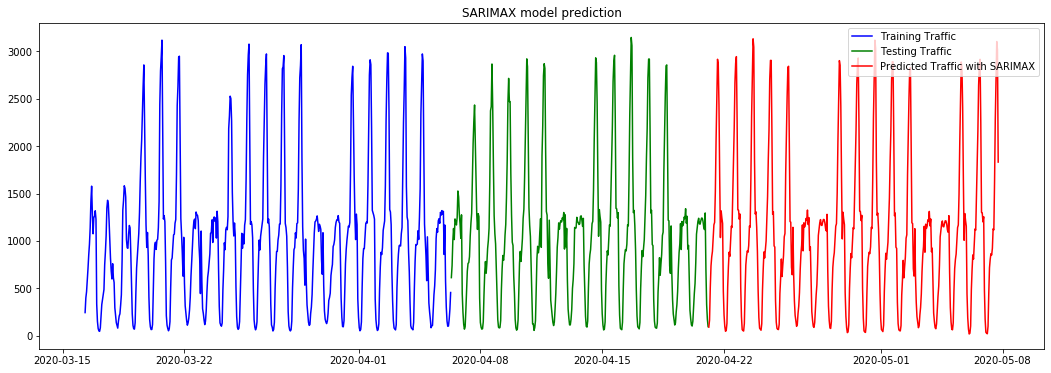

In [41]:
# Plot the results
plt.figure(figsize=(18,6))
plt.plot(y_to_train, 'b-', label='Training Traffic')
plt.plot(y_to_test, 'g', label='Testing Traffic')
plt.plot(forecast, 'r', label='Predicted Traffic with SARIMAX')
plt.legend(loc='upper right', frameon=True)
plt.title('SARIMAX model prediction')
plt.show()

## Visualize forecast for 400 periods

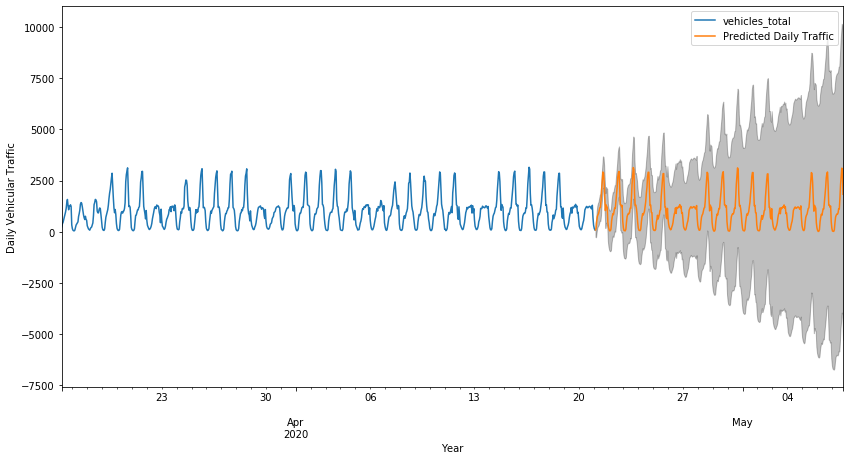

In [26]:
# Producing and visualizing forecasts

pred_uc = results.get_forecast(steps=400)
pred_ci = pred_uc.conf_int()
ax = data.plot(label='Observed Passengers', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Predicted Daily Traffic')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('Daily Vehicular Traffic')
plt.legend()
plt.show()